In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from pathlib import Path
import itertools 

from cycler import cycler

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from matplotlib import rcParams

from scipy.spatial.distance import pdist, squareform

import numpy as np
import pandas as pd
import cmocean
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import geopandas as gpd

import intro_plots as ip
from papercolors import colordict as pcd

paper_path = Path('../figures/')


rcParams['font.family'] = 'dejavu sans'
rcParams['figure.dpi'] = 200

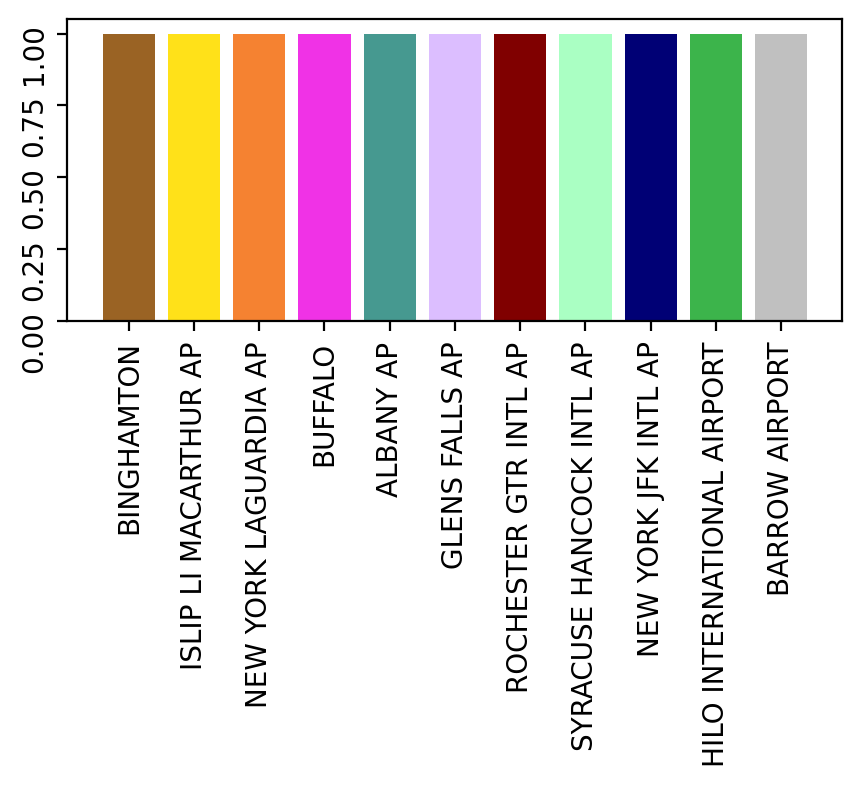

In [5]:
fig, ax = plt.subplots(figsize=(5,2))
ax.bar(ip.cdict.keys(), 1, color=ip.cdict.values())
ax.tick_params(rotation=90)

In [6]:
ny_all = pd.read_csv("nydata")

In [7]:
ny = ny_all[ny_all['NAME'].isin(ip.ssubset)].copy().fillna(0)

ny['DATES'] = pd.to_datetime(ny['DATE'])

ny['TEMP (°F)'] = ny['TAVG'].apply(lambda x: f"{x:2.2f}")
ny['PRCP (in.)'] = ny['PRCPI'].apply(lambda x: f"{x:1.4f}")    

In [8]:
ny['NAME'].unique()

array(['ALBANY AP', 'BINGHAMTON', 'GLENS FALLS AP',
       'ISLIP LI MACARTHUR AP', 'NEW YORK JFK INTL AP',
       'NEW YORK LAGUARDIA AP', 'ROCHESTER GTR INTL AP', 'SARA NEW YORK',
       'SCHROON LAKE NEW YORK', 'STONYKILL NEW YORK',
       'SYRACUSE HANCOCK INTL AP'], dtype=object)

In [9]:
stations = ['NEW YORK LAGUARDIA AP', 'ALBANY AP', 'NEW YORK JFK INTL AP','ISLIP LI MACARTHUR AP', 'ROCHESTER GTR INTL AP']
date = '2021-01-01'
all_fields = ny[ny['NAME'].isin(stations)& (ny['DATE'] == date)].set_index('NAME').loc[stations].reset_index()

In [10]:
all_fields

,NAME,LATITUDE,LONGITUDE,DATE,PRCP,TAVG,TAVGF,PRCPS,PRCPI,DATES,TEMP (°F),PRCP (in.)
0,NEW YORK LAGUARDIA AP,40.7794,-73.8803,2021-01-01,168.0,34.0,38.12,16.8,0.661416,2021-01-01,34.00,0.6614
1,ALBANY AP,42.7431,-73.8092,2021-01-01,66.0,-27.0,27.14,6.6,0.259842,2021-01-01,-27.00,0.2598
2,NEW YORK JFK INTL AP,40.6386,-73.7622,2021-01-01,160.0,22.0,35.96,16.0,0.629920,2021-01-01,22.00,0.6299
3,ISLIP LI MACARTHUR AP,40.7939,-73.1017,2021-01-01,152.0,21.0,35.78,15.2,0.598424,2021-01-01,21.00,0.5984
4,ROCHESTER GTR INTL AP,43.1167,-77.6767,2021-01-01,56.0,-2.0,31.64,5.6,0.220472,2021-01-01,-2.00,0.2205


In [11]:
distances = pdist(all_fields[['LATITUDE', 'LONGITUDE']].values, metric='euclidean')
dist_matrix = squareform(distances)

In [12]:
dist_matrix

array([[0.        , 1.96498674, 0.18377228, 0.77873501, 4.45820864],
       [1.96498674, 0.        , 2.10502476, 2.07362892, 3.88550295],
       [0.18377228, 2.10502476, 0.        , 0.67851186, 4.63295692],
       [0.77873501, 2.07362892, 0.67851186, 0.        , 5.13088928],
       [4.45820864, 3.88550295, 4.63295692, 5.13088928, 0.        ]])

In [107]:
network = [(0, 2), (0, 4), (3,4), (1,3), (2, 0)]

In [13]:
sample = all_fields[['NAME', 'TEMP (°F)','PRCP (in.)']]

,NAME,TEMP (°F),PRCP (in.)
0,NEW YORK LAGUARDIA AP,34.00,0.6614
1,ALBANY AP,-27.00,0.2598
2,NEW YORK JFK INTL AP,22.00,0.6299
3,ISLIP LI MACARTHUR AP,21.00,0.5984
4,ROCHESTER GTR INTL AP,-2.00,0.2205


In [24]:
pd.concat([sample, pd.DataFrame(dist_matrix, columns=sample['NAME'])], axis=1).to_csv("plot_data", index=False)

In [250]:
np.hstack([np.atleast_2d(['a', 'b', 'c', 'd', 'e']).T, dist_matrix])

array([['a', '0.0', '1.9649867429578205', '0.18377227756111975',
        '0.7787350062762158', '4.4582086368854394'],
       ['b', '1.9649867429578205', '0.0', '2.1050247623246636',
        '2.0736289181046845', '3.8855029545735706'],
       ['c', '0.18377227756111975', '2.1050247623246636', '0.0',
        '0.6785118569339954', '4.632956924038895'],
       ['d', '0.7787350062762158', '2.0736289181046845',
        '0.6785118569339954', '0.0', '5.130889283545303'],
       ['e', '4.4582086368854394', '3.8855029545735706',
        '4.632956924038895', '5.130889283545303', '0.0']], dtype='<U32')

In [27]:
def make_plot(sout, dims=None, paper=False):
    dims = [] if dims is None else dims
    mosaic = [['function', 'image'], ['1D', '2D'],[ 'table', 'nodes'], ['net', 'net']]
    fig, axd = plt.subplot_mosaic(mosaic, figsize=(8,8), facecolor='white')
       
    for ax in axd.values():
        ax.axis('off')
        ax.set_facecolor('white')
        
    oc = 'C4'
    
    x = np.linspace(-0.25, 1.25, 5)
    shuf = [2,0,3,1,4]
    y=np.repeat(.5, 5)
    yjit = y + [-.1, .05, .1, .15, -.02]
    xshuf = x[shuf]

    
    
    if 'table' in dims:
               
        tab = ip.plot_table(axd['table'], sample, ccolors=['k']*3, edgecolor=pcd['section'])
        fig.canvas.draw()
        
        [tab[0,c].get_text().set_color(pcd['fiber']) for c in range(3)]

        for i, (sn, xi, yi) in enumerate(zip(sample['NAME'], x,y)):
            xt, yt = ip.source_cell(tab[i+1,0],'k', xr=(i/10)+.5)
            station = tab[(i+1,0)].get_text().get_text()
            for c in range(3):
                tab[(i+1,c)].set_facecolor(ip.cdict[station])
                tab[(i+1,c)].set_alpha(.25)
                tab[(i+1,c)].get_text().set_color("black")
        
        nrows, ncols = dist_matrix.shape
        
        cnames = np.atleast_2d([ip.airport_codes[name] for name in sample['NAME']])
        diag = np.vstack([np.hstack([cnames.T, np.char.decode(dist_matrix.astype('S4'),'ascii')]), np.insert(cnames, 0, "")])
        tab_d = axd['nodes'].table(diag, loc=[0])
        tab_d.auto_set_font_size(False)
        tab_d.set_fontsize('medium')
        tab_d.scale(1.5, 1.5)
        tab_d.auto_set_column_width(np.arange(ncols))
                                    
        for i, (xj, yj) in enumerate(zip(xshuf, yjit)):
            station = tab[(i+1,0)].get_text().get_text()
            axd['net'].scatter(xj, yj, s=250, 
                              color=mcolors.to_rgba(ip.cdict[station], alpha=1), 
                              edgecolor=pcd['base'], lw=2, zorder=10)
            
        axd['net'].set(xlim=(-0.5, 1.5), ylim=(.25, .75))
        
    
        for i in range(0, nrows):
            for j in range(i, ncols):
                axd['net'].plot([xshuf[i], xshuf[j]], [yjit[i], yjit[j]], color=pcd['base'], zorder=-1, lw=2.5)
                tab_d[i,j+1].set_visible(False)
               
        tab_d[0,0].set_visible(False)
        tab_d[nrows, ncols].set_visible(False)
        tab_d[nrows,0].set_visible(False)
        
        for i, j in itertools.product(range(nrows), range(ncols)):
            tab_d[i,j].set_edgecolor(pcd['section'])
        
        for i, cn in enumerate(cnames.flatten()):
            tab_d[i, 0].set_color(ip.cdict[ip.rac[cn]])
            tab_d[i, 0].set_alpha(.25)
            tab_d[i, 0].set_edgecolor(pcd['section'])
            
        for j, cn in enumerate(cnames.flatten()):   
            tab_d[nrows, j+1].set_color(ip.cdict[ip.rac[cn]])
            tab_d[nrows, j+1].set_alpha(.25)
            tab_d[nrows, j+1].set_edgecolor(pcd['section'])
                
    if 'function' in dims:
        axd['function'].text(0.5, 0.5, r'$f(x)=\frac{1}{\sqrt{2\pi}}e^{x^2}$', transform=axd['function'].transAxes, fontsize=30, ha='center', va='center')
        x = np.linspace(-5,5,10000)
        y = lambda x: (1/np.sqrt(2*np.pi))*np.e**(-x**2/2)
        axd['function'].plot(x, y(x), alpha=.5, lw=10, color=pcd['section'])
        axd['function'].set(xlim=(-5,5))
    
    if '1D' in dims:
        axd['1D'].plot([-5,5], [.5, .5], color=pcd['base'], lw=10)
        axd['1D'].set(xlim=(-5, 5), ylim=(.25, .75))


    if 'image' in dims:
        nrows, ncols = np.array(mosaic).shape
        loc = (np.ravel(mosaic)=='image').nonzero()[0][0] + 1
        axd['image'] =  plt.subplot(nrows, ncols, loc, projection=ccrs.Robinson())
        axd['image'].stock_img()
        axd['image'].coastlines()

    if '2D' in dims:
        r = mpatches.Rectangle((.25,.25), .5, .5, color=pcd['base'])
        axd['2D'].add_artist(r)

    fig.savefig(sout, bbox_inches='tight', facecolor='white', edgecolor='black')
    plt.show()
    return axd

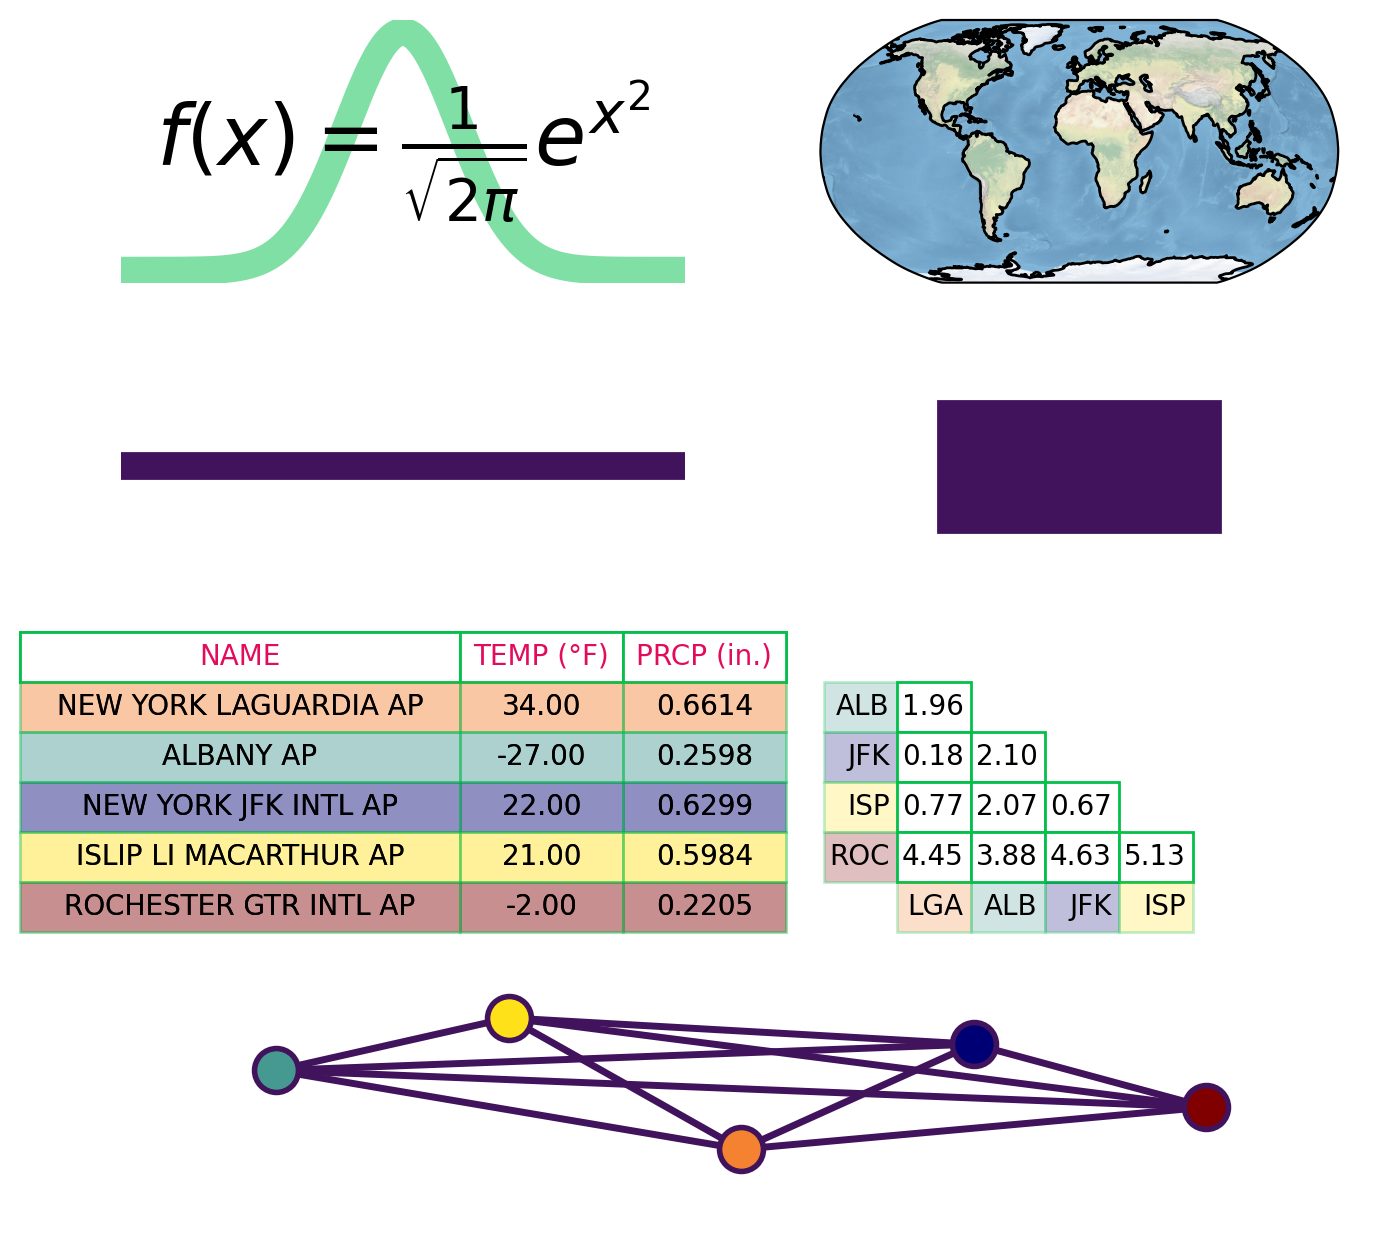

In [28]:
axd = make_plot(paper_path/"k_different_types", 
                dims=['table', '0D', 'function', '1D', 'image', '2D', 'nodes', 'net'], paper=True)

In [314]:
(np.array([1,2,3])==1).nonzero()[0][0]

0